In [ ]:
#default_exp alignments

In [ ]:
#slow_all

# alignments

> A submodule containing classes and functions for working directly with aligned reads

In [ ]:
#export
from tqdm import tqdm
import pysam
import seaborn
import numpy
import scipy
from matplotlib import pyplot
from copy import copy
import pandas as pd

_is_reverse2strand={False:'+', True:'-'}
_is_forward2strand={True:'+', False:'-'}
_cigar_keys={0:'M',
            1:'I',
            2:'D',
            3:'N'}

I want to analyze the reads that span each junction included in the rMATS output files. In particular, I want the data organized such that it is easy to assess for patterns of bias that could obscure biological signal. I don't want to do any realignments if it can be avoided, so I would like to the alignment files on the ENCODE website.

I'm going to use `pysam` to parse through these bamfiles and identify all read pairs where at least one read contains a splice junction. I will construct classes for organizing these reads and 

I need to match together the read pairs, first. Then I need to identify all readpairs where one end spans a splice junction. Then I need to get a good estimate of the GC-content of each read pair.

In [ ]:
#export

def mates_are_opposite_strands(read):
    """Check whether a read and its mate are on opposite strands. It is still possible the 
    read pairs are discordant, because this does not have access to the order in which the
    reads fall on a chromosome.
        Arguments:
            read (pysam alignment)
        Returns:
            result (bool)"""
    return read.is_reverse!=read.mate_is_reverse

def get_transcribed_strand(read):
    """Given a pysam alignment, return the transcribed strand.
        Arguments:
            read (pysam alignment)
        Returns:
            '+' if read 2 is on the plus strand
            '-' if read 2 is on the minus strand
            '?' if both reads 1 and 2 are on the same strand."""
    if mates_are_opposite_strands(read)==False:
        return '?'
    
    is_read_2=read.is_read1==False
    is_reverse=read.is_reverse
    if is_read_2==True:
        transcribed_strand=_is_reverse2strand[is_reverse]
    else:
        transcribed_strand=_is_reverse2strand[is_reverse==False]
    return transcribed_strand
    

In [ ]:
#export
class SimplifiedAlignedRead():
    """A reduced representation of the `pysam` alignment class"""
    strand={False:'+', True:'-'}
    def __init__(self,read,
                keep_sequence=False):
#         self.read=read
        self.cigarstring=read.cigarstring
        self.cigar=read.cigar
        self.name=read.query_name
        self.blocks=read.get_blocks()
        self.chrom=read.reference_name
        self.start=read.reference_start
        self.end=read.reference_end
        self.is_reverse=read.is_reverse
        self.is_read1=read.is_read1
        self.transcribed_strand=get_transcribed_strand(read)
        self.reference_positions=set(read.get_reference_positions())
        if keep_sequence==True:
            self.reference_sequence=read.get_reference_sequence()
            self.query_sequence=read.query_sequence
        self.strand=SimplifiedAlignedRead.strand[self.is_reverse]
        
        
        if self.strand=='+':
            self.pos5=self.start
            self.pos3=self.end
        else:
            self.pos3=self.start
            self.pos5=self.end
            
        self.is_paired=read.is_paired
        self.is_proper_pair=read.is_proper_pair
        
    def get_splice_junctions(self):
        return get_junctions_from_blocks(self.chrom, self.transcribed_strand, 
                                        self.blocks, self. cigar)
        
class ReadPair():
    strand={False:'+', True:'-'}
    def __init__(self, reads=[],
                 keep_sequence=False,
                 stranded=True,
                 second_read_is_transcribed_strand=True,
                 primer_length=6):
        """Organizes a read pair.
            Arguments:
                reads (list or tuple): The forward and reverse reads, in any order
                stranded (bool, default: True): Is the data stranded?
                second_read_is_transcribed_strand (bool default: True): Self-descriptive.
                    If true, read 2 is taken to be the strand of the transcribed sequence. 
                    Otherwise, read 1 is used.
                primer_length (int): 
        """
        assert len(reads)==2
        assert reads[0].query_name.strip()==reads[1].query_name.strip()
        for read in reads:
            if read.is_read1==True:
                self.read1=SimplifiedAlignedRead(read, keep_sequence=keep_sequence)
            else:
                self.read2=SimplifiedAlignedRead(read,keep_sequence=keep_sequence)
        #Read one was the first strand transcribed
#         self.primer_sequence=self.read1.query_sequence[:primer_length]
        #The read 2 in the pair matches the strandedness of the transcribed sequence
        if stranded==True:
            if second_read_is_transcribed_strand==True:
                self.transcribed_strand=self.read2.strand
            else:
                self.transcribed_strand=self.read1.strand
        else:
            self.transcribed_strand=''
        self.pos=self.read2.pos5
        self.chrom=self.read2.chrom
        self.overlap=len(self.read1.reference_positions&self.read2.reference_positions)
        if keep_sequence==False:
            del self.read1.reference_positions
            del self.read2.reference_positions
         
        #Test to make sure this works properly
        if self.transcribed_strand=="+":
            self.is_concordant=self.read1.pos5<self.read2.pos5
        elif self.transcribed_strand=="-":
            self.is_concordant=self.read2.pos5<self.read1.pos5
        else:
            self.is_concordant=False
#     def as_pickle_friendly(self):
#         clone=copy(self)
#         del clone.read1.read
#         del clone.read2.read
#         return clone

In [ ]:
fname="/home/mpm289/projects/SplicingMapAnalyses/00_data/00_RNAi/aligned_reads/TIA1_K562/kd/ENCFF425JBA.bam"
samfile = pysam.AlignmentFile(fname)

In [ ]:
cigar_codes={}
for r in tqdm(samfile):
    cigar=r.cigar

    for t in cigar:
        if t[0] not in cigar_codes:
            cigar_codes[t[0]]=0
        cigar_codes[t[0]]+=1

55595432it [00:49, 1132406.80it/s]


In [ ]:
samfile = pysam.AlignmentFile(fname)
readpairs={}
for i in tqdm(range(40000)):
    r=next(samfile)
    qname=r.qname
#     if qname not in jxn_names: continue
    if r.is_secondary: continue
    if qname not in readpairs:
        readpairs[qname]=[]
        
    readpairs[qname].append(r)

100%|██████████| 40000/40000 [00:00<00:00, 53885.16it/s]


In [ ]:
[(k, len(readpairs[k])) for k in readpairs.keys()][:20]

[('USSD-TL1-1227:179:C4E9UACXX:8:2113:4827:46550', 2),
 ('USSD-TL1-1227:179:C4E9UACXX:8:1116:19696:55900', 2),
 ('USSD-TL1-1227:179:C4E9UACXX:8:1208:16186:97045', 2),
 ('USSD-TL1-1227:179:C4E9UACXX:8:1310:3407:12376', 2),
 ('USSD-TL1-1227:179:C4E9UACXX:8:1314:3165:26411', 2),
 ('USSD-TL1-1227:179:C4E9UACXX:8:2106:12994:22242', 2),
 ('USSD-TL1-1227:179:C4E9UACXX:8:2114:4958:32560', 2),
 ('USSD-TL1-1227:179:C4E9UACXX:8:2114:15677:73394', 2),
 ('USSD-TL1-1227:179:C4E9UACXX:8:2116:20625:35822', 2),
 ('USSD-TL1-1227:179:C4E9UACXX:8:2206:1237:95462', 2),
 ('USSD-TL1-1227:179:C4E9UACXX:8:2213:8535:3432', 2),
 ('USSD-TL1-1227:179:C4E9UACXX:8:2213:16877:94930', 2),
 ('USSD-TL1-1227:179:C4E9UACXX:8:2214:3821:21987', 2),
 ('USSD-TL1-1227:179:C4E9UACXX:8:1208:8969:59725', 2),
 ('USSD-TL1-1227:179:C4E9UACXX:8:1311:11451:25586', 2),
 ('USSD-TL1-1227:179:C4E9UACXX:8:1311:8397:30963', 2),
 ('USSD-TL1-1227:179:C4E9UACXX:8:2308:9440:63811', 2),
 ('USSD-TL1-1227:179:C4E9UACXX:8:2312:10389:75699', 2),
 ('

In [ ]:
[get_transcribed_strand(r) for r in readpairs['USSD-TL1-1227:179:C4E9UACXX:8:2113:4827:46550']]

['+', '+']

In [ ]:
[(r.is_reverse, r.is_read1) for r in readpairs['USSD-TL1-1227:179:C4E9UACXX:8:2113:4827:46550']]

[(False, False), (True, True)]

In [ ]:
reads=[]
for r in tqdm(range(10000)):
    reads.append(next(samfile))

100%|██████████| 10000/10000 [00:00<00:00, 976145.97it/s]


In [ ]:
reads[2].qname

'USSD-TL1-1227:179:C4E9UACXX:8:1208:16186:97045'

In [ ]:
reads[0].

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 13),
 (14, 14),
 (15, 15),
 (16, 16),
 (17, 17),
 (18, 18),
 (19, 19),
 (20, 20),
 (21, 21),
 (22, 22),
 (23, 23),
 (24, 24),
 (25, 25),
 (26, 26),
 (27, 27),
 (28, 28),
 (29, 29),
 (30, 30),
 (31, 31),
 (32, 32),
 (33, 33),
 (34, 34),
 (35, 35),
 (36, 36),
 (37, 37),
 (38, 38),
 (39, 39),
 (40, 40),
 (41, 41),
 (42, 42),
 (43, 43),
 (44, 44),
 (45, 45),
 (46, 46),
 (47, 47),
 (48, 48),
 (49, 49),
 (50, 50),
 (51, 51),
 (52, 52),
 (53, 53),
 (54, 54),
 (55, 55),
 (56, 56),
 (57, 57),
 (58, 58),
 (59, 59),
 (60, 60),
 (61, 61),
 (62, 62),
 (63, 63),
 (64, 64),
 (65, 65),
 (66, 66),
 (67, 67),
 (68, 68),
 (69, 69),
 (70, 70),
 (71, 71),
 (72, 72),
 (73, 73),
 (74, 74),
 (75, 75),
 (76, 76),
 (77, 77),
 (78, 78),
 (79, 79),
 (80, 80),
 (81, 81),
 (82, 82),
 (83, 83),
 (84, 84),
 (85, 85),
 (86, 86),
 (87, 87),
 (88, 88),
 (89, 89),
 (90, 90),
 (91, 91),
 (92, 92

In [ ]:
samfile = pysam.AlignmentFile(fname)
jxn_names={}
for r in tqdm(samfile):
    qname=r.qname
    try:
        if r.cigarstring.count('N')!=0:
            jxn_names[qname]=True
    except:
        continue


55595432it [01:02, 890135.24it/s] 


In [ ]:
reads[0].is_proper_pair

True

In [ ]:
strand_dict={}
for r in reads:
    strand=get_transcribed_strand(r)
    if strand not in strand_dict:
        strand_dict[strand]=0
    strand_dict[strand]+=1

In [ ]:
reads[0].cigarstring

'100M'

In [ ]:
jxn_reads=[]
for r in reads:
    if r.cigarstring.find('N')>0:
        jxn_reads.append(r)

In [ ]:
#export
def parse_cigar(cigar):
    """Given a cigar string, return the parts."""
    try:
        return [(_cigar_keys[t[0]], t[1]) for t in cigar ]
    except:
        raise ValueError('Cigar must only contain M,I,D, and N. Soft clipped alignments not yet supported.')

In [ ]:
for i in range (1000):
    cigar=jxn_reads[i].cigar
    skip=True
    for t in cigar:
        if t[0]!=0 and t[0]!=3:
            skip=False
    if skip==True: continue
    print (i,jxn_reads[i].cigarstring, jxn_reads[i].cigar)
    print ()

222 37M757N59M2D4M [(0, 37), (3, 757), (0, 59), (2, 2), (0, 4)]

252 3M659N92M1I4M [(0, 3), (3, 659), (0, 92), (1, 1), (0, 4)]

256 44M1D34M92N22M [(0, 44), (2, 1), (0, 34), (3, 92), (0, 22)]

362 95M1D177N5M [(0, 95), (2, 1), (3, 177), (0, 5)]

593 28M177N22M1D50M [(0, 28), (3, 177), (0, 22), (2, 1), (0, 50)]

671 3M177N22M1D75M [(0, 3), (3, 177), (0, 22), (2, 1), (0, 75)]

986 18M1D47M172N35M [(0, 18), (2, 1), (0, 47), (3, 172), (0, 35)]



In [ ]:
reads[0]

In [ ]:
get_junctions_from_blocks('chr1','+',jxn_reads[222].get_blocks(), jxn_reads[222].cigar)

[('chr1', '+', '15038', '15795')]

In [ ]:
parse_cigar(jxn_reads[222].cigar)

[('M', 37), ('N', 757), ('M', 59), ('D', 2), ('M', 4)]

In [ ]:
jxn_reads[222].get_blocks()

[(15001, 15038), (15795, 15854), (15856, 15860)]

In [ ]:
#export


In [ ]:
determine_which_gaps_are_splice_junctions(jxn_reads[222].cigar)

[True, False]

Now I need to use the cigar to determine which gaps are exon-exon junctions. This means I 

In [ ]:
#export

def determine_which_gaps_are_splice_junctions(cigar):
    """For each gap in the read alignment (either exon-exon junction, deletion, or insertion), 
    return whether it represents a splice junction"""
    parsed_cigar=parse_cigar(cigar)
    gap_is_splice_junction=[]
    for operation, length in parsed_cigar:
        if operation=='N': gap_is_splice_junction.append(True)
        elif operation=='D': gap_is_splice_junction.append(False)
        elif operation=='I': gap_is_splice_junction.append(False)
    return gap_is_splice_junction
def get_junctions_from_blocks(chrom, 
                              strand, 
                              exon_blocks, 
                              cigar):
    """Given the necessary information, determine the splice junctions in a read.
    ****    
    Arguments:
            chrom (str): The chromosome the read aligned to
            strand (str): The strand of the transcript
            exon_blocks (list): The results of pysam.libcalignedsegment.AlignedSegment.get_blocks()
            cigar (list): The contents of pysam.libcalignedsegment.AlignedSegment.cigar
        Returns:
            results (list): A list of the splice junctions in the read, organized as tuples
                (chrom, strand, start, end). Note the order of the start and end is ascending."""

    junctions=[]
    is_splice_junction=determine_which_gaps_are_splice_junctions(cigar)
    if len(exon_blocks)==1: return []
    for i,exon in enumerate(exon_blocks[:-1]):
        try:
            if is_splice_junction[i]==False: continue  #Skip gaps that reflect deletions
        except:
            print (is_splice_junction)
            print (exon_blocks)
            print (cigar)
            print (jabber)
        junctions.append((chrom, strand ,str(exon[-1]),str(exon_blocks[i+1][0])))
    return junctions
def extract_junctions_from_pysam_read(read):
    """"""

    exon_blocks=read.get_blocks()
    cigar=read.cigar
    chrom=read.reference_name
    strand=get_transcribed_strand(read)
    return get_junctions_from_blocks(chrom, strand,exon_blocks, cigar)
    
    

def extract_junctions_from_simplified_read(read):
    """"""
    exon_blocks=read.blocks
    cigar=read.cigar
    chrom=read.chrom
    strand=read.transcribed_strand
    if len(exon_blocks)==1: return []
    return get_junctions_from_blocks(chrom, strand, exon_blocks, cigar)
    
def extract_junctions_from_readpair(readpair):
#     exon_blocks=read.blocks
    chrom=readpair.chrom
    strand=readpair.transcribed_strand
    
    junctions=set()
    for read in [readpair.read1, readpair.read2]:
        read_jxns=extract_junctions_from_read(read)
        for jxn in read_jxns:
            chrom,start,end=jxn
            junctions.add(f"{chrom},{strand},{start},{end}")
            
    return list(junctions)

In [ ]:
#export
def get_all_splice_junctions_from_bamfile(fname, 
                                          min_mapq=10, 
                                          use_only_primary=True, 
                                          second_read_is_transcribed_strand=True):
    """
    Identify all splice junctions in bamfile.
        Arguments
            fname (str): the path to the bamfile
            min_mapq (int): the minimum mapping quality required to consider a read
            use_only_primary (bool): Whether to only consider junctions in primary alignments
    """
    samfile = pysam.AlignmentFile(fname)
    jxn_names=set()
    for r in tqdm(samfile):
        qname=r.qname
        if r.mapq<min_mapq:continue
        if use_only_primary==True and r.is_secondary==True: continue
        try:
            if r.cigarstring.count('N')!=0:
                jxns=set([','.join(j) for j in extract_junctions_from_pysam_read(r)])
                jxn_names|=set(jxns)
        except:
            continue
    return jxn_names

In [ ]:
#export
def get_splice_junction_counts_from_bamfile(fname, 
                                          min_mapq=10, 
                                          use_only_primary=True, 
                                          second_read_is_transcribed_strand=True):
    """
    Iterates over a bamfile and returns the set of splice junctions identified
        Arguments
            fname (str): the path to the bamfile
    """
    samfile = pysam.AlignmentFile(fname)
    jxn_counts={}
    for r in tqdm(samfile):
        qname=r.qname
        if r.mapq<min_mapq:continue
        if r.is_secondary==True: continue
        try:
            if r.cigarstring.count('N')!=0:
                jxns=[','.join(j) for j in extract_junctions_from_pysam_read(r)]
                for j in jxns:
                    if j not in jxn_counts:
                        jxn_counts[j]=0
                    jxn_counts[j]+=1 
        except:
            continue
    jxn_table={'id':[],
              'chrom':[],
              'strand':[],
              'start':[],
              'end':[],
              'count':[]}
    for j,v in jxn_counts.items():
        chrom, strand, start, end=j.split(',')
        jxn_id=f"{chrom}({strand}):{start}-{end}"
        jxn_table['id'].append(jxn_id)
        jxn_table['chrom'].append(chrom)
        jxn_table['strand'].append(strand)
        jxn_table['start'].append(start)
        jxn_table['end'].append(end)
        jxn_table['count'].append(v)
    df=pd.DataFrame.from_dict(jxn_table)
    return df

                

In [ ]:
#export
def get_splice_junction_counts_from_bamfile_readpairs(fname, 
                                          min_mapq=10, 
                                          use_only_primary=True, 
                                          second_read_is_transcribed_strand=True):
    """
    Iterates over a bamfile and returns the set of junctions spanned by reads and the number of readpairs \
    with reads containing each junction. Avoids double-counting (e.g. if both reads in a pair contain a junction) \
    by record the set of read pair ids that
    
        Arguments
            fname (str): the path to the bamfile
    """
    samfile = pysam.AlignmentFile(fname)
    jxn_counts={}
    for r in tqdm(samfile):
        qname=r.qname
        if r.mapq<min_mapq:continue
        if r.is_secondary==True: continue
        try:
            if r.cigarstring.count('N')!=0:
                jxns=[','.join(j) for j in extract_junctions_from_pysam_read(r)]
                for j in jxns:
                    if j not in jxn_counts:
                        jxn_counts[j]=set()
                    jxn_counts[j].add(qname)
        except:
            continue
    for j in jxn_counts:
        jxn_counts[j]=len(jxn_counts[j])
        
    jxn_table={'id':[],
              'chrom':[],
              'strand':[],
              'start':[],
              'end':[],
              'count':[]}
    for j,v in jxn_counts.items():
        chrom, strand, start, end=j.split(',')
        jxn_id=f"{chrom}({strand}):{start}-{end}"
        jxn_table['id'].append(jxn_id)
        jxn_table['chrom'].append(chrom)
        jxn_table['strand'].append(strand)
        jxn_table['start'].append(start)
        jxn_table['end'].append(end)
        jxn_table['count'].append(v)
    df=pd.DataFrame.from_dict(jxn_table)
    return df

                

In [ ]:
all_jxns=get_all_splice_junctions_from_bamfile(fname="/home/mpm289/projects/SplicingMapAnalyses/00_data/00_RNAi/aligned_reads/TIA1_K562/kd/ENCFF425JBA.bam")

55595432it [01:45, 526755.57it/s] 


In [ ]:
jxn_counts_raw=get_splice_junction_counts_from_bamfile(fname="/home/mpm289/projects/SplicingMapAnalyses/00_data/00_RNAi/aligned_reads/TIA1_K562/kd/ENCFF425JBA.bam")

55595432it [01:41, 546124.99it/s]


In [ ]:
jxn_counts=get_splice_junction_counts_from_bamfile_readpairs(fname="/home/mpm289/projects/SplicingMapAnalyses/00_data/00_RNAi/aligned_reads/TIA1_K562/kd/ENCFF425JBA.bam")

55595432it [01:44, 533924.07it/s]


In [ ]:
jxn_counts

id chrom strand      start        end  count
0               chr1(-):14501-15004  chr1      -      14501      15004      1
1               chr1(-):15038-15310  chr1      -      15038      15310      1
2               chr1(-):14829-14969  chr1      -      14829      14969     26
3               chr1(-):15038-15795  chr1      -      15038      15795     12
4               chr1(-):15947-16606  chr1      -      15947      16606      1
...                             ...   ...    ...        ...        ...    ...
193259  chrX(+):155253125-155253784  chrX      +  155253125  155253784     12
193260  chrX(+):155253937-155254696  chrX      +  155253937  155254696     15
193261  chrX(+):155254714-155254905  chrX      +  155254714  155254905      3
193262  chrX(+):155254765-155254905  chrX      +  155254765  155254905     25
193263  chrX(+):155254765-155254891  chrX      +  155254765  155254891      1

[193264 rows x 6 columns]

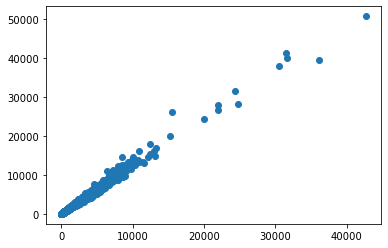

In [ ]:
pyplot.scatter(jxn_counts['count'].values,jxn_counts_raw['count'].values)

In [ ]:
sorted(list(all_jxns))[:40]

['chr1,+,10002840,10003306',
 'chr1,+,10002840,10003406',
 'chr1,+,10003573,10032075',
 'chr1,+,10007565,10032075',
 'chr1,+,10007623,10007754',
 'chr1,+,100111918,100127874',
 'chr1,+,100127955,100133197',
 'chr1,+,100133322,100152231',
 'chr1,+,100152346,100152485',
 'chr1,+,100152519,100152631',
 'chr1,+,100152745,100154330',
 'chr1,+,100154426,100159574',
 'chr1,+,100155428,100159574',
 'chr1,+,100174676,100174753',
 'chr1,+,100174815,100175999',
 'chr1,+,100174815,100176353',
 'chr1,+,100174815,100176361',
 'chr1,+,100176505,100176910',
 'chr1,+,100176505,100177660',
 'chr1,+,100176505,100177973',
 'chr1,+,100177088,100177660',
 'chr1,+,100177576,100177660',
 'chr1,+,100177719,100177973',
 'chr1,+,100178071,100181141',
 'chr1,+,100181228,100182965',
 'chr1,+,100181228,100185089',
 'chr1,+,100183081,100185089',
 'chr1,+,100185203,100194048',
 'chr1,+,100194196,100195205',
 'chr1,+,100195304,100203641',
 'chr1,+,100203824,100206348',
 'chr1,+,100203824,100207734',
 'chr1,+,100203824

In [ ]:
samfile = pysam.AlignmentFile(fname)
readpairs={}
for r in tqdm(samfile):
    qname=r.qname
    if qname not in jxn_names: continue
    if r.is_secondary: continue
    if qname not in readpairs:
        readpairs[qname]=[]
        
    readpairs[qname].append(r)

55595432it [01:07, 825977.80it/s] 


In [ ]:
raw_jxns=[]
simp_jxns=[]
for r in tqdm(jxn_reads):
    
    raw_jxns.append (extract_junctions_from_pysam_read(r))
#     except:
#         print (r.cigarstring)
#         print (jabber)
    simp_read=SimplifiedAlignedRead(r)
#     simp_jxns.append (extract_junctions_from_simplified_read(simp_read))
    simp_jxns.append (simp_read.get_splice_junctions())
    

100%|██████████| 219438/219438 [00:03<00:00, 69032.71it/s]


In [ ]:
simp_jxns==raw_jxns

True

In [ ]:
organized_readpairs=[]
for rp in tqdm(readpairs.keys()):
    jxn_count=0
    for r in readpairs[rp]:
        jxn_count+=r.cigarstring.count('N')
    if jxn_count==0: continue
#     organized_readpairs.append(ReadPair(readpairs[rp]))
    try:
        organized_readpairs.append(ReadPair(readpairs[rp]))
    except:
        print (readpairs[rp][0].qname, readpairs[rp][1].qname)
        print (len(readpairs[rp]))
        print ([r.mapq for r in readpairs[rp]])
        print (jabber)
        

100%|██████████| 8504181/8504181 [02:51<00:00, 49522.78it/s]


In [ ]:
len(organized_readpairs)

8499517

In [ ]:
def estimate_overlap_slow(rp):
    pos1=set(rp.read1.read.get_reference_positions())
    pos2=set(rp.read2.read.get_reference_positions())
    return len(pos2&pos1)
def estimate_length_slow(rp):
    pos1=set(rp.read1.read.get_reference_positions())
    pos2=set(rp.read2.read.get_reference_positions())
    return len(pos2)+len(pos1)-len(pos2&pos1)
# set(organized_readpairs[0].read1.read.get_reference_positions())&set(organized_readpairs[0].read2.read.get_reference_positions())

In [ ]:
organized_readpairs[0].read1.read.get_reference_sequence()

In [ ]:
estimate_length_slow(organized_readpairs[0])

139

In [ ]:
overlaps=[]
for i in tqdm(range(len(organized_readpairs))):
    if organized_readpairs[i].read1.read.mapq<10 or organized_readpairs[i].read2.read.mapq<10:
        continue
    overlaps.append(estimate_overlap_slow(organized_readpairs[i]))
overlaps=numpy.array(overlaps)

100%|██████████| 8499517/8499517 [01:02<00:00, 136650.10it/s]


/home/mpm289/anaconda3/envs/txmap/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

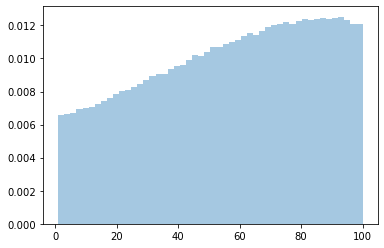

In [ ]:
seaborn.distplot(overlaps[overlaps>0], kde=False, norm_hist=True)

In [ ]:
from collections import 

In [ ]:
def nbinom_param(mu,logdisp):
    disp=2**logdisp
    var=mu+disp*mu**2
    p=mu/var
    n=mu**2/(var-mu)
    return p, n
def truncated_nbinom_lk(x,mu,logdisp,b):
    p,n=nbinom_param(mu,logdisp)
    z=scipy.stats.nbinom.logcdf(b,n=n,p=p)
    return (scipy.stats.nbinom.logpmf(x,n=n,p=p)-z)
    

In [ ]:
x=numpyat

30.0432
0.921305625232859


/home/mpm289/anaconda3/envs/txmap/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


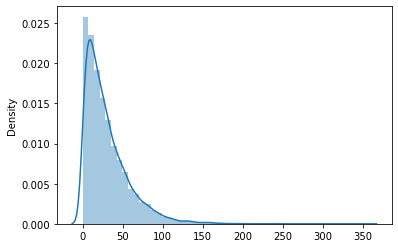

In [ ]:
p,n=nbinom_param(30, -.3)
k=scipy.stats.nbinom.rvs(n=n,p=p,size=10000)
seaborn.distplot(k)
print (numpy.mean(k))
print (numpy.std(k)/numpy.mean(k))

/home/mpm289/anaconda3/envs/txmap/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

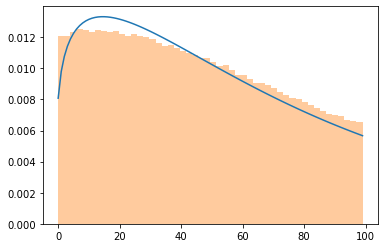

In [ ]:
xdom=numpy.arange(0,100)
# truncated_nbinom_lk(xdom, 30,-.3,100.)
pyplot.plot(xdom,numpy.exp(truncated_nbinom_lk(xdom, 80,-0.3,100.)))
seaborn.distplot(100-overlaps[overlaps>0], kde=False, norm_hist=True)

In [ ]:
def compute_trunc_nbinom_lk(val, counts,)

In a SAM file, the CIGAR string describes how an aligned read corresponds the reference sequence, indicating the sequence of matches (M), insertions (I), and deletions (D), among other possibiilities. Specific to RNA-to-genome alignments, introns are denoted in the CIGAR string as "N" ([SAM specification, page 8](https://samtools.github.io/hts-specs/SAMv1.pdf)). So to find reads that contain splice junctions, we can just look for reads that contain at least one "N" in the CIGAR string.

In [ ]:
counter=0
spliced_reads=[]
double_jxns=[]
for r in tqdm(reads):
    #If there's no CIGAR string, skip the read; it's probably unaligned
    if isinstance (r.cigarstring,type(None)): 
        continue
    jxn_count=r.cigarstring.count('N')
    
    if jxn_count>0:           #If there's no "N", .find() returns -1
        spliced_reads.append(r)
    if jxn_count>1:
        double_jxns.append(r)
        


In [ ]:
len(double_jxns)

In [ ]:
min_size=[]
for d in double_jxns:
    blocks=d.get_blocks()
    lengths=[b[1]-b[0] for b in blocks]
    min_size.append(min(lengths))

In [ ]:
seaborn.distplot(min_size, kde=False)

In [ ]:
import seaborn
jxn_count=[]
for s in tqdm(spliced_reads):
    jxn_count.append(s.cigarstring.count('N'))
seaborn.distplot(jxn_count, kde=False, norm_hist=False)

In [ ]:
len(spliced_reads)

In [ ]:
print (spliced_reads[0])

We'll used `.get_blocks()` to split the alignment and recover the exonic intervals. This should work perfectly if there are no other gaps in the alignment. But if there are indels, we'll need a procedure for identifying the splice junctions. Either way, it shouldn't be that complicated to determine a splice junction for each read.

In [ ]:
spliced_reads[0].get_blocks()

In [ ]:
def extract_junctions(read):
    exon_blocks=read.blocks
    chrom=read.chrom
    strand=read.strand
    if len(exon_blocks)==1: return []
    junctions=[]
    for i,exon in enumerate(exon_blocks[:-1]):
#         print (i,exon)
        junctions.append(f"{chrom}:{str(exon[-1])}-{str(exon_blocks[i+1][0])}")
    return junctions

In [ ]:
for i in range(20):
    print (extract_junctions_from_readpair(organized_readpairs[i]))

['chr1,+,11671,12009']
['chr1,-,14829,14969']
['chr1,-,15038,15310', 'chr1,-,14501,15004']
['chr1,-,14829,14969']
['chr1,-,14829,14969']
['chr1,-,14829,14969']
['chr1,-,14829,14969']
['chr1,-,15038,15795']
['chr1,-,14829,14969']
['chr1,-,15038,15795', 'chr1,-,14829,14969']
['chr1,-,15038,15795']
['chr1,-,14829,14969']
['chr1,-,14829,14969']
['chr1,-,14829,14969']
['chr1,-,14829,14969']
['chr1,-,15038,15795', 'chr1,-,14829,14969']
['chr1,-,14829,14969']
['chr1,-,14829,14969']
['chr1,-,14829,14969']
['chr1,-,15038,15795']


In [ ]:
jxn_dict={}
for rp in tqdm(organized_readpairs):
    jxns=extract_junctions_from_readpair(rp)
#     if len(jxns)!=1: continue
    for key in jxns:
        if key not in jxn_dict:
            jxn_dict[key]=[]
        jxn_dict[key].append(rp)

100%|██████████| 8499517/8499517 [00:50<00:00, 167567.74it/s]


In [ ]:
jxn_dict={}
for rp in tqdm(organized_readpairs):
    for s in [rp.read1]:
        jxns=extract_junctions(s)
        if len(jxns)!=1: continue
        key=jxns[0]
        if key not in jxn_dict:
            jxn_dict[key]=[]
        jxn_dict[key].append(rp)

100%|██████████| 8499517/8499517 [00:10<00:00, 848447.58it/s]


In [ ]:
keys=[k for k in jxn_dict.keys()]

In [ ]:
keys[:10]

['chr1,+,11671,12009',
 'chr1,-,14829,14969',
 'chr1,-,15038,15310',
 'chr1,-,14501,15004',
 'chr1,-,15038,15795',
 'chr1,-,15854,15856',
 'chr1,-,15059,15795',
 'chr1,-,15947,16606',
 'chr1,-,16698,16698',
 'chr1,-,15901,15903']

In [ ]:
jxn_dict[keys[1]][0].overlap

0

In [ ]:
import pickle

with open('01_outputs/jxn_dict.pckl',mode='wb') as handle:
    pickle.dump(jxn_dict, handle)

In [ ]:
extract_junctions(spliced_reads[0])

In [ ]:
# jxn_dict={}
# for s in tqdm(spliced_reads):
#     jxns=extract_junctions(s)
#     if len(jxns)>1: continue
#     key='-'.join(jxns[0])
#     if key not in jxn_dict:
#         jxn_dict[key]=[]
#     jxn_dict[key].append(s)

In [ ]:
keys=[k for k in jxn_dict.keys()]

In [ ]:
def plot_splice_graph(jxns, scale=.2):
    for jxn in jxns:
        chrom,interval=jxn.split(':')
        left,right=interval.split('-')
        left=int(left)
        right=int(right)
        dist=right-left
        h=scale*(dist)**1.1
        pyplot.plot((left,left+.5*dist), [0,h], c='black', lw=2)
        pyplot.plot((left+.5*dist, right), [h,0], c='black', lw=2)
    pyplot.show()

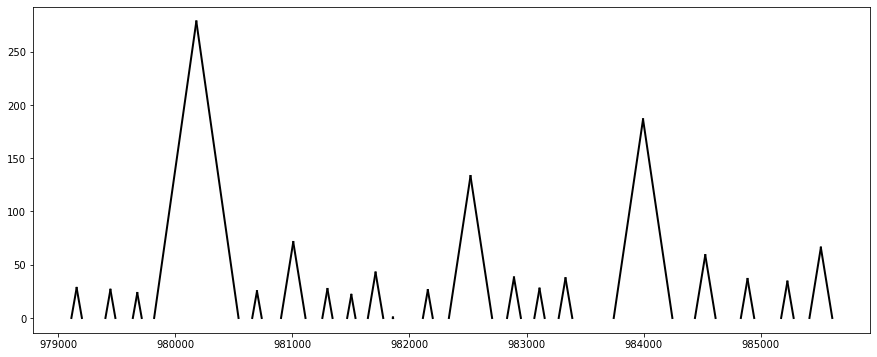

In [ ]:
pyplot.figure(figsize=(15,6))
plot_splice_graph(keys[200:220])

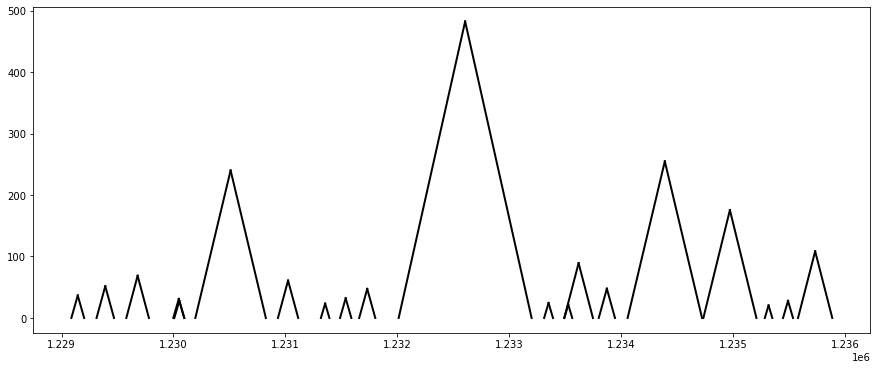

In [ ]:
pyplot.figure(figsize=(15,6))
plot_splice_graph(keys[300:320])

In [ ]:
for k in keys[200:220]:
    print (k, len(jxn_dict[k]))

chr1:979112-979202 16
chr1:979403-979488 22
chr1:979637-979713 29
chr1:980657-980738 16
chr1:979819-980540 21
chr1:980903-981112 35
chr1:981256-981343 19
chr1:981468-981539 20
chr1:981645-981776 38
chr1:981858-981860 1
chr1:982337-982706 11
chr1:982834-982952 32
chr1:982115-982199 7
chr1:983067-983155 43
chr1:983275-983391 11
chr1:983745-984246 10
chr1:984439-984615 10
chr1:984831-984945 31
chr1:985175-985282 13
chr1:985417-985612 23


In [ ]:
# for jxn in keys[200:300]:
#     if len(jxn_dict[jxn])<20: continue 
    
#     starts=[r.read1.pos5 for r in jxn_dict[jxn]]
#     ends=[r.read2.pos3 for r in jxn_dict[jxn]]
#     pyplot.scatter(starts, ends)
#     pyplot.title(jxn)
#     pyplot.show()

In [ ]:
from matplotlib import pyplot

I think read 2 ought to reflect the strand of the read pair

In [ ]:
jxn_dict['chr1:17055-17232'][10].read2.read.reference_end

17294

In [ ]:
jxn_dict['chr1:17055-17232'][10].read1.read.reference_start

16961

In [ ]:
jxn_dict['14829-14969'][0].reference_end

KeyError: '14829-14969'

In [ ]:
jxn_id='17368-17605'
starts,ends=[],[]
kmers={}
# for k in keys[:]:
#     for r in jxn_dict[k]:
#         starts.append(r.read1.read.reference_start)
#         ends.append(r.read1.read.reference_end)
#         kmer=r.read1.read.query_alignment_sequence[:6]
#         if kmer not in kmers: kmers[kmer]=0
#         kmers[kmer]+=1


In [ ]:
# jxn_id='17055-17232'

# jxn_id='324345-324438'
jxn_id='chr1:983067-983155'
starts,ends=[],[]
kmers={}
for r in jxn_dict[jxn_id]:
    starts.append(r.read1.read.reference_start)
    ends.append(r.read2.read.reference_end)

/home/mpm289/anaconda3/envs/txmap/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

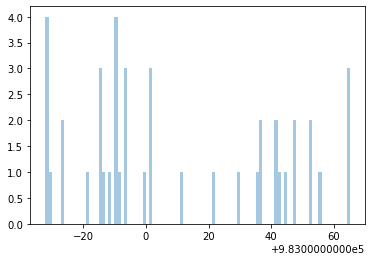

In [ ]:
seaborn.distplot(starts, bins=(max(starts)-min(starts)), kde=False)

chr1:1153068-1153837


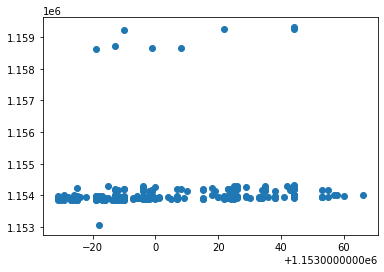

chr1:1154013-1154148


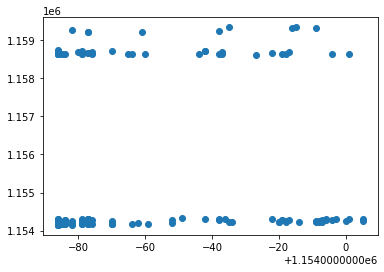

chr1:1154307-1158623


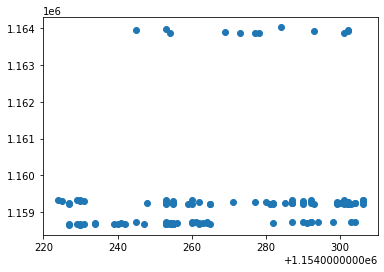

chr1:1158737-1159211


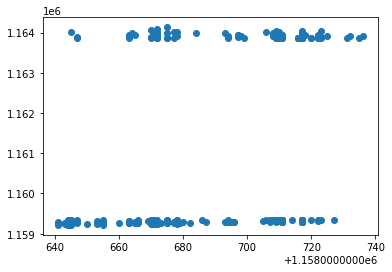

chr1:1159348-1163847


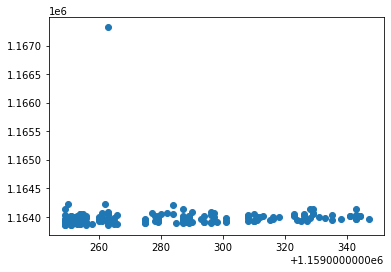

chr1:1164326-1167271


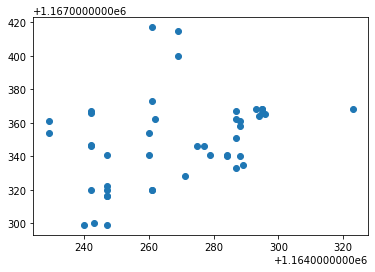

chr1:1190867-1191424


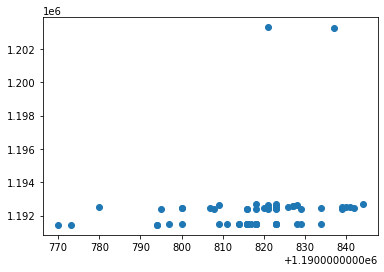

chr1:1191505-1192371


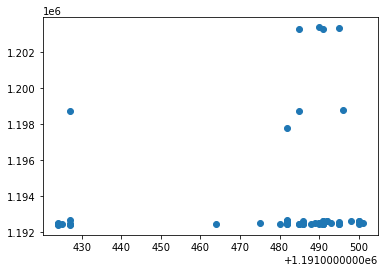

chr1:1192510-1192587


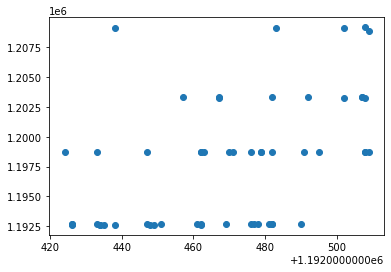

chr1:1192690-1198725


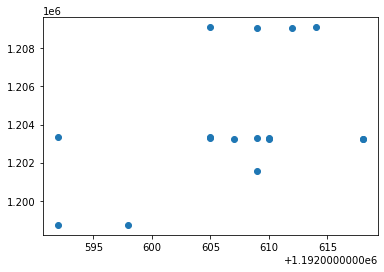

In [ ]:
for k in keys[240:280]:
    starts,ends=[],[]

    for r in jxn_dict[k]:
        starts.append(r.read1.read.reference_start)
        ends.append(r.read2.read.reference_end)
    if len(starts)<10: continue
    pyplot.scatter(starts, ends)
    print(k)
    pyplot.show()

In [ ]:
jxn_reads={}
for key in tqdm( jxn_dict.keys()):
    part1=
    jxn_reads[key]=[]
    for r in jxn_dict[key]:
        jxn_reads[key].append(((r.read1.pos5,r.read1.pos3),(r.read2.pos3,r.read2.pos5)))

100%|██████████| 167639/167639 [00:04<00:00, 37064.25it/s]


In [ ]:
import pickle
with open('01_outputs/jxn_dict.pckl',mode='wb') as handle:
    pickle.dump(jxn_reads,handle)

In [ ]:
jxn_key='chr1:1154307-1158623'
# jxn_key='chr1:1192510-1192587'
for r in jxn_dict[jxn_key]:
    print ( (r.read1.pos5,r.read1.pos3),(r.read2.pos3,r.read2.pos5))

(1154224, 1158640) (1159221, 1159321)
(1154225, 1158641) (1158727, 1159301)
(1154227, 1158643) (1154256, 1158672)
(1154227, 1158643) (1158681, 1159255)
(1154227, 1158643) (1154251, 1158667)
(1154227, 1158643) (1158638, 1159212)
(1154229, 1158645) (1154273, 1158689)
(1154229, 1158645) (1159224, 1159324)
(1154230, 1158646) (1154249, 1158665)
(1154230, 1158646) (1154262, 1158678)
(1154230, 1158646) (1154240, 1158656)
(1154230, 1158646) (1159213, 1159313)
(1154230, 1158646) (1159240, 1159340)
(1154231, 1158647) (1154261, 1158677)
(1154231, 1158647) (1159217, 1159317)
(1154234, 1158650) (1154279, 1158695)
(1154234, 1158650) (1154260, 1158676)
(1154239, 1158655) (1154275, 1158691)
(1154240, 1158656) (1154253, 1158669)
(1154241, 1158657) (1154305, 1158721)
(1154242, 1158658) (1154273, 1158689)
(1154245, 1158661) (1159340, 1163939)
(1154245, 1158661) (1158628, 1158728)
(1154247, 1158663) (1154267, 1158683)
(1154248, 1158664) (1158674, 1159248)
(1154253, 1158669) (1158638, 1159212)
(1154253, 11

<AxesSubplot:>

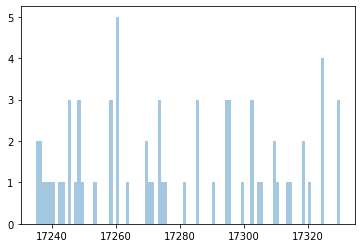

In [ ]:
seaborn.distplot(ends, bins=(max(ends)-min(ends)), kde=False)

In [ ]:
jxn_count=[]
for s in tqdm(spliced_reads):
    jxn_count.append(s.cigarstring.count('N'))

100%|██████████| 15827490/15827490 [00:11<00:00, 1328065.07it/s]


In [ ]:
del_count=[]
for s in tqdm(spliced_reads):
    del_count.append(s.cigarstring.count('D'))

100%|██████████| 15827490/15827490 [00:12<00:00, 1304352.44it/s]


/home/mpm289/anaconda3/envs/txmap/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

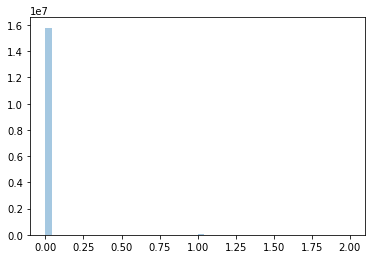

In [ ]:
seaborn.distplot(del_count, kde=False, norm_hist=False)

In [ ]:
import itertools


In [ ]:
kmers_classes=[''.join(k) for k in itertools.product('ATGC', repeat=6)]
kmers={}
for k in kmers_classes:
    kmers[k]=1.

In [ ]:

# for k in tqdm(keys[:]):
#     for r in jxn_dict[k]:
#         kmer=r.read1.read.query_alignment_sequence[:6]
#         if kmer not in kmers: continue
#         if kmer not in kmers: kmers[kmer]=0
#         kmers[kmer]+=1
for k in tqdm(keys[:]):
    for r in jxn_dict[k]:
        kmer=r.read2.read.query_alignment_sequence[-6:]
        if kmer not in kmers: continue
        if kmer not in kmers: kmers[kmer]=0
        kmers[kmer]+=1


100%|██████████| 174313/174313 [00:03<00:00, 48047.84it/s]


In [ ]:
print (len(kmers.keys()))

4096


In [ ]:
import pickle
with open('01_outputs/ctrl_dict.pckl',mode='rb') as handle:
    ctrl_kmers=pickle.load(handle)

In [ ]:
kd,ctrl=[],[]
for k in kmers.keys():
    if k not in ctrl_kmers: continue
    kd.append(kmers[k])
    ctrl.append(ctrl_kmers[k])
kd=numpy.array(kd)
ctrl=numpy.array(ctrl)

In [ ]:
f_kd={}
f_ctrl={}
for k in kmers.keys():
    f_kd[k]=kmers[k]/kd.sum()
    f_ctrl[k]=ctrl_kmers[k]/ctrl.sum()

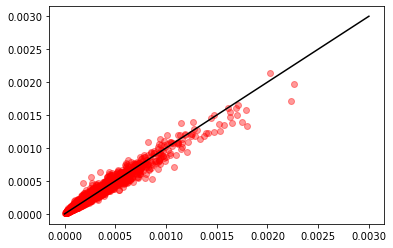

In [ ]:
pyplot.scatter((ctrl)/ctrl.sum(),(kd)/kd.sum(),c='r', alpha=.4)
pyplot.plot([0,.003],[0,.003], c='black')

In [ ]:
p_ctrl=(ctrl)/ctrl.sum()
p_kd=(kd)/kd.sum()

<AxesSubplot:>

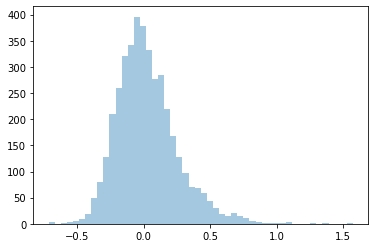

In [ ]:
seaborn.distplot(numpy.log2(p_kd/p_ctrl)[(kd>100)&(ctrl>100)], kde=False)

In [ ]:
bias_kd=[]
bias_ctrl=[]
for k in tqdm(keys[:]):
    seq=jxn_dict[k][0].read1.read.query_sequence
    bk=0
    bc=0
    for i in range(len(seq)-6):
        kmer=seq[i:i+6]
        if kmer not in f_kd: continue
        bk+=(f_kd[kmer])
        bc+=(f_ctrl[kmer])
    bias_ctrl.append(bc)
    bias_kd.append(bk)
        

100%|██████████| 174313/174313 [00:06<00:00, 27048.87it/s]


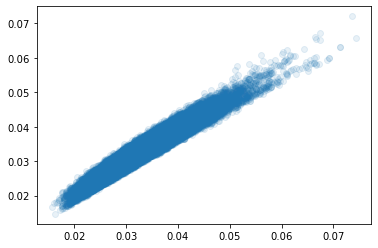

In [ ]:
pyplot.scatter(bias_ctrl,bias_kd, alpha=.1)

<AxesSubplot:>

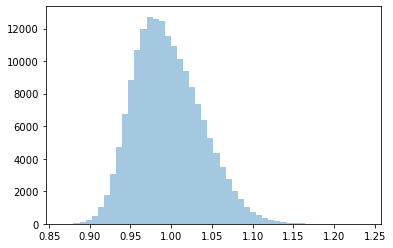

In [ ]:
seaborn.distplot(2**(numpy.log2(bias_kd)-numpy.log2(bias_ctrl)),kde=False)